In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
turnstile_data_source = 'http://web.mta.info/developers/data/nyct/turnstile/'
    
turnstile_filename1 = 'turnstile_190713.txt'
#st = turnstile_data_source + '/' + turnstile_filename1

df = pd.read_csv(turnstile_data_source + '/' + turnstile_filename1)

In [3]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [4]:
# rename columns since the last column, 'EXITS', contains trailing whitespace
df.columns = df.columns.str.replace(r'\s+', '')

df["EXITS"] = pd.to_numeric(df["EXITS"])

# Use domain knowledge to select subway stops in and near the Flatiron district where there are many tech companies
df_23st = df[df['STATION'].str.contains('23 ST')]

# Four subway stops either in or near the Flatiron district
flatiron = df_23st[df_23st['LINENAME'].str.contains('NRW')]
gramercy = df_23st[df_23st['LINENAME'].str.contains('6')]
east_chelsea = df_23st[df_23st['LINENAME'].str.contains('F')]
union_sq = df[df['STATION'].str.contains('14 ST-UNION SQ')]

Examine exits at different times in at the FI stop.

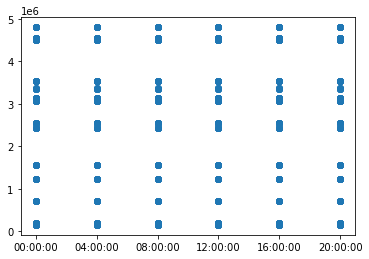

In [5]:
plt.scatter(x=flatiron['TIME'], y=(flatiron['EXITS']).astype(int))

This is not very helpful because times are in four-hour increments. 

To verify, let's sample the data and look at the TIME column: 16, 12, 0, 8, etc.

In [6]:
flatiron.sample(200)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
4502,A031,R083,00-03-02,23 ST,NRW,BMT,07/12/2019,12:00:00,REGULAR,160750,202698
4233,A030,R083,01-06-01,23 ST,NRW,BMT,07/09/2019,16:00:00,REGULAR,85870117,1228136
4177,A030,R083,01-06-00,23 ST,NRW,BMT,07/07/2019,08:00:00,REGULAR,8640281,4541655
4039,A030,R083,01-00-02,23 ST,NRW,BMT,07/12/2019,08:00:00,REGULAR,5216297,2428361
4378,A031,R083,00-00-02,23 ST,NRW,BMT,07/12/2019,20:00:00,REGULAR,6591447,3528798
...,...,...,...,...,...,...,...,...,...,...,...
4315,A031,R083,00-00-01,23 ST,NRW,BMT,07/09/2019,08:00:00,REGULAR,4671961,1562993
4282,A031,R083,00-00-00,23 ST,NRW,BMT,07/10/2019,20:00:00,REGULAR,1341572,719014
4454,A031,R083,00-03-01,23 ST,NRW,BMT,07/11/2019,12:00:00,REGULAR,4081051,4505342
4493,A031,R083,00-03-02,23 ST,NRW,BMT,07/11/2019,00:00:00,REGULAR,158825,200036


In [7]:
flatiron[flatiron["C/A"]=="A030"].shape

(336, 11)

In [8]:
flatiron[flatiron["C/A"]=="A031"].shape

(252, 11)

In [9]:
flatiron[flatiron["UNIT"]=="R083"].shape

(588, 11)

In [10]:
252+336

588

In [11]:
flatiron[flatiron["UNIT"]=="R083"].tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
4500,A031,R083,00-03-02,23 ST,NRW,BMT,07/12/2019,04:00:00,REGULAR,160494,201861
4501,A031,R083,00-03-02,23 ST,NRW,BMT,07/12/2019,08:00:00,REGULAR,160530,202033
4502,A031,R083,00-03-02,23 ST,NRW,BMT,07/12/2019,12:00:00,REGULAR,160750,202698
4503,A031,R083,00-03-02,23 ST,NRW,BMT,07/12/2019,16:00:00,REGULAR,161112,203047
4504,A031,R083,00-03-02,23 ST,NRW,BMT,07/12/2019,20:00:00,REGULAR,161655,203413


Could do a groupby to aggregate the average or sum of entries at each time of day. 

What about by days of the week?

What about by days of the week?

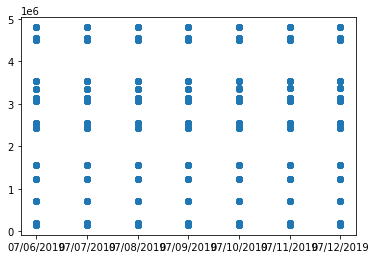

In [12]:
plt.scatter(x=flatiron['DATE'], y=(flatiron['EXITS']).astype(int))

I don't think I understand yet what the 'EXITS' column really means yet.  Even within the same week at the same time interval 

there are many datapoints.

To go further, we probably need to review the 'codebook' for this dataset. Otherwise we can end up with a garbage-in analysis

*******
## Update 


I've figured out the issue here. The entries and exits columns are actually cumulative counts for each specific counting device. Therefore to extract the data we need, we need to is the following:
0. Convert ENTRIES and EXITS columns to integers so we can compute their numerical diff
1. Convert it into a list of dataframes where each dataframe in the list corresponds to a counting device. (To do this we first extract the unique values in the device column; then cycle through that list, using each item to extract rows matching it.
2. Then cycle through each data frame in our list of dataframes
    * sort it by TIME just to be on the safe side
    * create two new columns that contains the difference between each row's ENTRY and EXIT counts and that of the previous row
3. Append each of dataframe in the result list into a one list
4. Sort by date and time to find graph these to discover days and times with highest traffic
5. might use a calendar library ot convert date to day of week and do groupby on that
6. could also graph traffic against TIME, while ignorning day
7. Ideally we could drill down and find the day-of-week and time that consistently have the highest traffic during the summer. This would require the above pipeline for multiple weeks and multiple years, and pooling that data.



Unfortunately the "Field description" actually doesn't explain which column corresponds to the counting device. Is it `C/A` or it it `Unit`? 

In [13]:
flatiron.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
3917,A030,R083,01-00-00,23 ST,NRW,BMT,07/06/2019,00:00:00,REGULAR,103161,147662
3918,A030,R083,01-00-00,23 ST,NRW,BMT,07/06/2019,04:00:00,REGULAR,103161,147672
3919,A030,R083,01-00-00,23 ST,NRW,BMT,07/06/2019,08:00:00,REGULAR,103161,147712
3920,A030,R083,01-00-00,23 ST,NRW,BMT,07/06/2019,12:00:00,REGULAR,103161,147867
3921,A030,R083,01-00-00,23 ST,NRW,BMT,07/06/2019,16:00:00,REGULAR,103161,148016


Let's see how many rows are in a single `C/A` and `UNIT`

In [14]:
flatiron[flatiron["C/A"]=="A030"].shape

(336, 11)

In [15]:
flatiron[flatiron["C/A"]=="A031"].shape

(252, 11)

In [16]:
flatiron[flatiron["UNIT"]=="R083"].shape

(588, 11)

In [17]:
336+252 == 588

True

Let's look at the seam between `C/A` == A030 and and A031, to see if the cumulative count restarts.

In [18]:
flatiron[flatiron["UNIT"]=="R083"].iloc[330:340]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
4247,A030,R083,01-06-01,23 ST,NRW,BMT,07/12/2019,00:00:00,REGULAR,85873540,1229834
4248,A030,R083,01-06-01,23 ST,NRW,BMT,07/12/2019,04:00:00,REGULAR,85873540,1229834
4249,A030,R083,01-06-01,23 ST,NRW,BMT,07/12/2019,08:00:00,REGULAR,85873552,1229875
4250,A030,R083,01-06-01,23 ST,NRW,BMT,07/12/2019,12:00:00,REGULAR,85873708,1230130
4251,A030,R083,01-06-01,23 ST,NRW,BMT,07/12/2019,16:00:00,REGULAR,85873993,1230363
4252,A030,R083,01-06-01,23 ST,NRW,BMT,07/12/2019,20:00:00,REGULAR,85874479,1230536
4253,A031,R083,00-00-00,23 ST,NRW,BMT,07/06/2019,00:00:00,REGULAR,1331659,714199
4254,A031,R083,00-00-00,23 ST,NRW,BMT,07/06/2019,04:00:00,REGULAR,1331726,714214
4255,A031,R083,00-00-00,23 ST,NRW,BMT,07/06/2019,08:00:00,REGULAR,1331752,714238
4256,A031,R083,00-00-00,23 ST,NRW,BMT,07/06/2019,12:00:00,REGULAR,1331991,714353


Indeed, the counting in `EXITS` jumps from 1230536 to 714199 at the seam from A030 to A031, so it seems that the C/A column contains the device label.

Looking further, however, what about the SCP colomn? Let's observe what happens to the EXITS column when SCP shifts.

In [19]:
flatiron[flatiron["UNIT"]=="R083"].iloc[375:380]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
4292,A031,R083,00-00-00,23 ST,NRW,BMT,07/12/2019,12:00:00,REGULAR,1344852,721052
4293,A031,R083,00-00-00,23 ST,NRW,BMT,07/12/2019,16:00:00,REGULAR,1345501,721255
4294,A031,R083,00-00-00,23 ST,NRW,BMT,07/12/2019,20:00:00,REGULAR,1346509,721476
4295,A031,R083,00-00-01,23 ST,NRW,BMT,07/06/2019,00:00:00,REGULAR,4668236,1561951
4296,A031,R083,00-00-01,23 ST,NRW,BMT,07/06/2019,04:00:00,REGULAR,4668289,1561957


Whoops. When SCP changes, the EXITS counts start again. So actually the combination of the C/A and SCP columns seem to 
define a counting stream

#### Try out a graph using the data from just one device

If this pans out, we'll go back and do this data cleaning at an earlier stage so it affects the entire dataset

In [21]:
FI_device_A031zeroSCP = flatiron[ (flatiron["C/A"]=="A031) & (flatiron["SCP"]=="00-00-00")].copy()
FI_device_A031zeroSCP.sort_values(by=["DATE", "TIME"]).head(10)

SyntaxError: invalid syntax (<ipython-input-21-06374c5d9984>, line 1)

In [ ]:
FI_device_A031zeroSCP["Exit diffs"] = FI_device_A031zeroSCP["EXITS"].diff()

In [ ]:
FI_device_A031zeroSCP[FI_device_A031zeroSCP["TIME"]=="00:00:00"]

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter( x=FI_device_A031zeroSCP['TIME'], y=FI_device_A031zeroSCP['Exit diffs'], marker='_', s=(800,))

##### It seems as though noon time (at least on certain days) as well as 8pm are the times with the most traffic.

In [ ]:
x_labels = ['Sat', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri'] 
plt.figure(figsize=(10,10))
positions = range(7)
plt.xticks(positions, x_labels)
plt.scatter( x=FI_device_A031zeroSCP['DATE'], y=FI_device_A031zeroSCP['Exit diffs'], marker='_', s=(800,))

#### It seems as though Wednesday and Thursday have the most traffic.

Meanwhile, what about the zip code of stations? We'll need to merge this with the turnstile data if we want to 

identify stops that that are higher-income neighborhoods, by joining (merging) with a demographics/census dataset

In [ ]:
stations = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [ ]:
stations.sample(10)

Whereas the stop names in the turnstile dataset were all caps, these are in title case. 

Who knows if truly corresponding names are used for each station?

As a preliminary step to finding out, lets convert that columns to upper 

In [ ]:
stations['Stop Name'] = stations['Stop Name'].str.upper() 

In [ ]:
# sanity check
stations.sample(5)

In [ ]:
stations.columns

Merge (join) the turnstile and stations dataframes.  We probably have too many columms here and should pare down.

In [ ]:
turnstile_station = df.merge(stations, left_on="STATION", right_on="Stop Name")
turnstile_station 

For this to be useful regarding income levels in neighborhoods (which will probably exists by zip code), 

we'd have to merge this station we'd have to use library that gets zip code from lat and longitude

I believe the one to use is probably geopy: 
[geopy](https://geopy.readthedocs.io/en/stable/)

These might or not be helpful:

[income by zip](https://www.incomebyzipcode.com/newyork)

[open data nyc](https://opendata.cityofnewyork.us/)    